
# WeightWatcher - VGG  ww2x

https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96


VGG is one of the first, large scale modern architectures based on the classic convolutional model of LeCun ,, resembling a larger scale version of LeNet5.  While there are earlier models (AlexNet, etc), VGG is usefukl because:

-  There are several variants, with 11, 13, 16, and 19 layers, and with and wthout Batch Normalization
-  It is widely available in pyTorch and other frameworks
-  There are versions trained on all of ImageNet, ImageNet-1K (a smaller data set), etc.
-  Although large,  is still used in Transfer Learning.

The general VGG series architecture consists of 

-  Several sets of Conv2D+ReLU layers (followed by Max Pooling), with feature maps increasing in size
-  3 final Fully Connected (Dense/Linear) layers

Below we show the VGG16 architecture, consisting of 16 layers.

The VGG series are considered very large models, with an enormous number of parameters comparexd to later models like ResNet and DenseNet series.  Most notably, compared to later models,

-  VGG models contain large, FC layers at the end
-  VGG does not contain residual connections


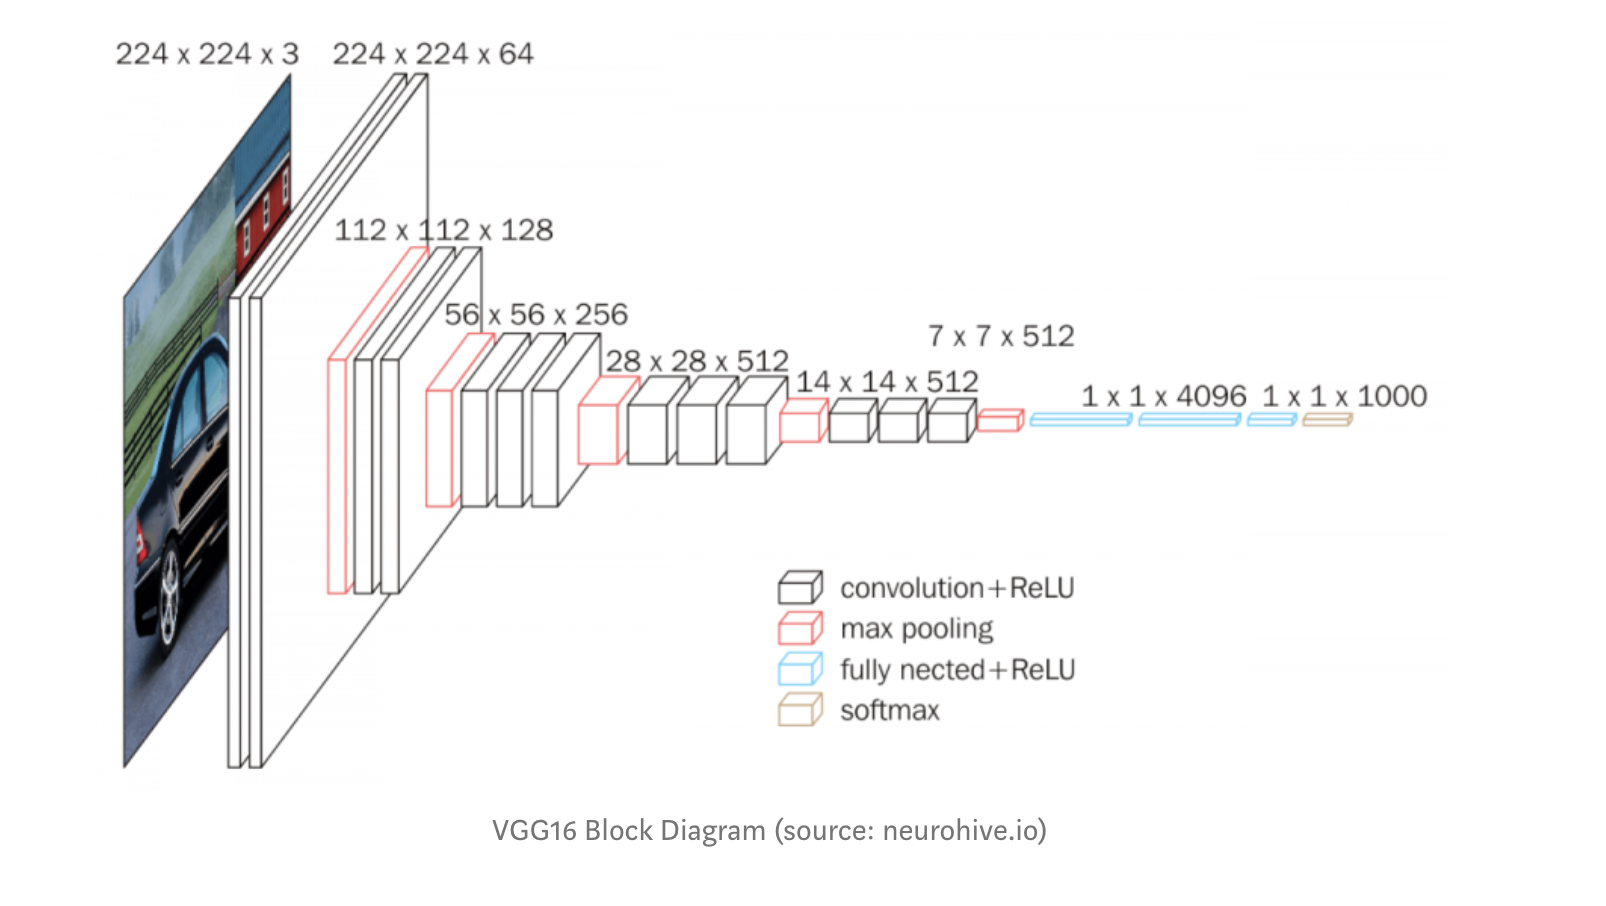

In [1]:
from IPython.display import Image
Image(filename='VGG16.1.png',width=800, height=400)


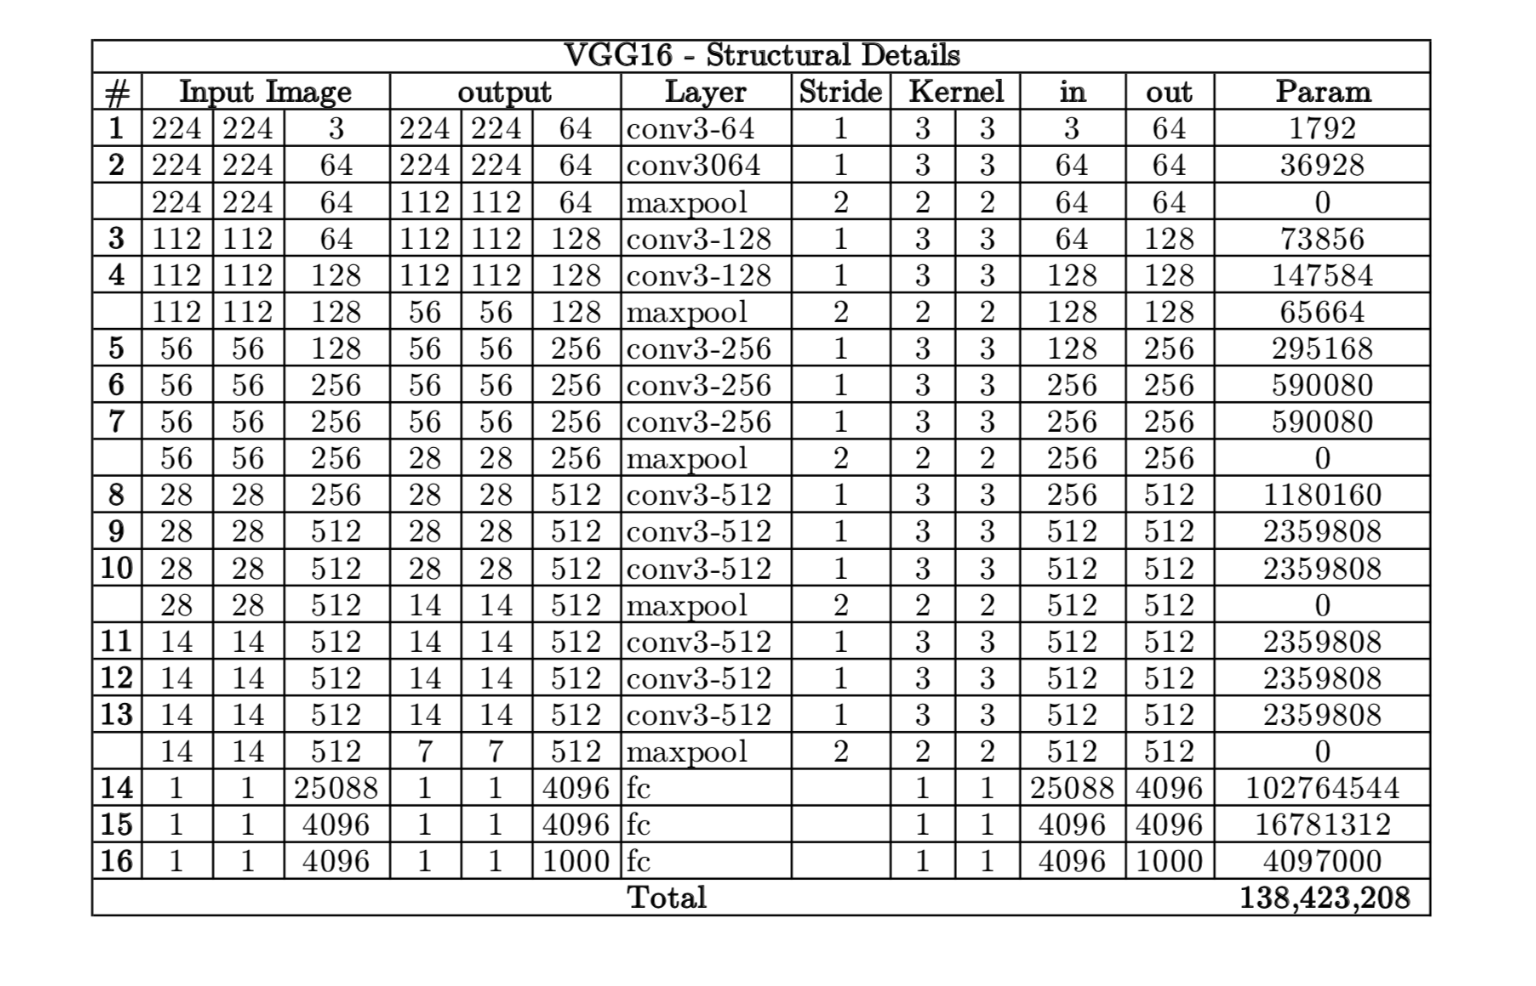

In [2]:
Image(filename='VGG16.2.png',width=800, height=400)

It is noted that the VGGNet model (16?) has ov er 2X the number of parameters as one of the largest ResNet models, with far less top5 accuracy.  

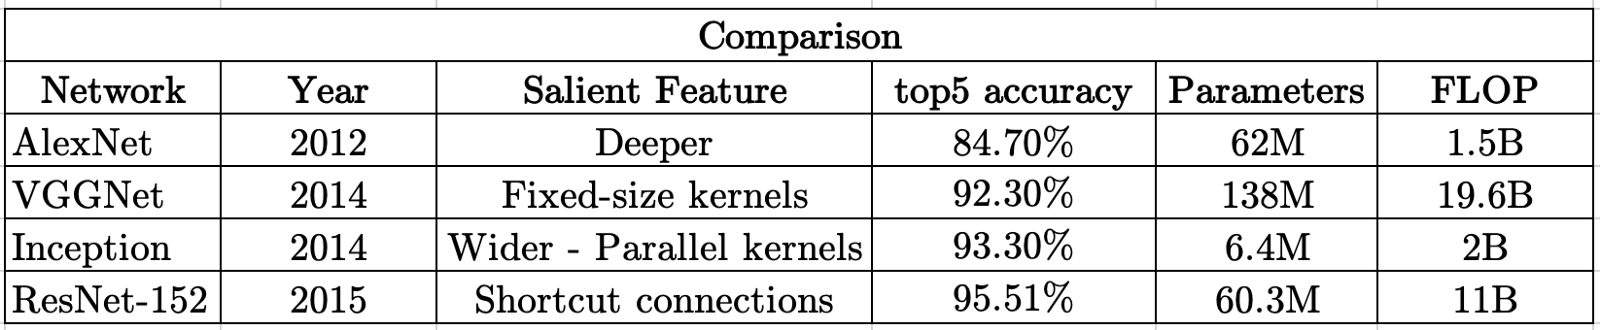

In [3]:
from IPython.display import Image
Image(filename='CV-models.png',width=800, height=400)

## Summary of results


We first compute the Average Alpha $\langle\alpha\rangle$ for all models, and compare to the Test Accuracy accross the models.  In contrast to expectations, and other models like ResNet, on average, $\langle\alpha\rangle$ is increasing with Test Accuracy instead of decreasing.  In fact, $\langle\alpha\rangle$ is strongly *negatively correlated* with reported Test Accuracy.  

#### Why is this ?

If we look at $\alpha$ vs Layer Id, we see that  $\alpha$ is increasing with Layer Id. That is, as information flows thorugh the network, the layers are less and less correlated.  THis suggests (to me) that the VGG networks are fairly bad at funneling information through the network.

Instead, we need to use the Weighted Alpha metric $\hat{\alpha}$ , which is positively correlated with the Test Accuracy.  

## Calculation of Results

In [4]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [6]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

import weightwatcher as ww
import torchvision.models as models

ww.__version__

'0.4.0'

###  Helper Notebook to make Plots


In [7]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

Pick colors from https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [8]:
series_name = 'VGG'
all_names = [ 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
colors =    ['indigo', 'blue',    'purple',  'cyan',   'darkgreen','goldenrod','darkorange','red']


all_models = []
all_models.append(models.vgg11(pretrained=True))
all_models.append(models.vgg11_bn(pretrained=True))

all_models.append(models.vgg13(pretrained=True))
all_models.append(models.vgg13_bn(pretrained=True))

all_models.append(models.vgg16(pretrained=True))
all_models.append(models.vgg16_bn(pretrained=True))

all_models.append(models.vgg19(pretrained=True))
all_models.append(models.vgg19_bn(pretrained=True))


series_name = 'VGG'
all_names = [ 'vgg11', 'vgg13',  'vgg16',  'vgg19', ]
colors =    ['indigo', 'purple','darkgreen', 'red']


all_models = []
all_models.append(models.vgg11(pretrained=True))

all_models.append(models.vgg13(pretrained=True))

all_models.append(models.vgg16(pretrained=True))

all_models.append(models.vgg19(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>VGG-11</p></td>
<td><p>30.98</p></td>
<td><p>11.37</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13</p></td>
<td><p>30.07</p></td>
<td><p>10.75</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16</p></td>
<td><p>28.41</p></td>
<td><p>9.62</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19</p></td>
<td><p>27.62</p></td>
<td><p>9.12</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-11 with batch normalization</p></td>
<td><p>29.62</p></td>
<td><p>10.19</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13 with batch normalization</p></td>
<td><p>28.45</p></td>
<td><p>9.63</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16 with batch normalization</p></td>
<td><p>26.63</p></td>
<td><p>8.50</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19 with batch normalization</p></td>
<td><p>25.76</p></td>
<td><p>8.15</p></td>
</tr>
</tbody>
</table>
</pre>

In [9]:
top1_errors= {
    
    "vgg11": 30.98,
    "vgg11_bn": 29.62,
    "vgg13": 30.07,
    "vgg13_bn": 28.45,
    "vgg16": 28.41,
    "vgg16_bn": 26.63,
    "vgg19": 27.62,
    "vgg19_bn": 25.76,
}

In [10]:
top5_errors= {
    
    "vgg11": 11.37,
    "vgg11_bn": 10.19,
    "vgg13": 10.75,
    "vgg13_bn": 9.63,
    "vgg16": 9.62,
    "vgg16_bn": 8.50,
    "vgg19": 9.12,
    "vgg19_bn": 8.15,
}

### Run WeightWatcher, collect summary and details (as dataframes) for all models

In [11]:
all_summaries, all_details = [], []
for im, name in enumerate(tqdm(all_names)):
    print(im, name)
    watcher = ww.WeightWatcher(model=all_models[im])
    details = watcher.analyze(plot=False, mp_fit=True, ww2x=True, min_evals = 50)
    all_details.append(details)
    all_summaries.append(watcher.get_summary(details))
    
    

  0%|          | 0/8 [00:00<?, ?it/s]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 50, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': True}
INFO:weightwatcher:Using weightwatcher 0.2x style layer and slice iterator
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 


0 vgg11


INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO

INFO:weightwatcher:MP Fitting Random layer: 13 None 
INFO:weightwatcher:LAYER: 13 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 13 None 
INFO:weightwatcher:Randomizing Layer: 13 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 13 None 
INFO:weightwatcher:LAYER: 13 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 13 None 
INFO:weightwatcher:Randomizing Layer: 13 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 13 None 
INFO:weightwatcher:LAYER: 13 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 13 None 
INFO:weightwatcher:Randomizing Layer: 13 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 13 None 
INFO:weightwatcher:LAYER: 13 8  : <class 'torch.nn.modul

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 20 None 
INFO:weightwatcher:LAYER: 20 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 20 None 
INFO:weightwatcher:Randomizing Layer: 20 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 20 None 
INFO:weightwatcher:LAYER: 20 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 20 None 
INFO:weightwatcher:Randomizing Layer: 20 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 20 None 
INFO:weightwatcher:LAYER: 20 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 20 None 
INFO:weightwatcher:Randomizing Layer: 20 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting R

1 vgg11_bn


INFO:weightwatcher:LAYER: 6 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 6 None 
INFO:weightwatcher:Randomizing Layer: 6 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 6 None 
INFO:weightwatcher:LAYER: 6 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 6 None 
INFO:weightwatcher:Randomizing Layer: 6 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 6 None 
INFO:weightwatcher:LAYER: 6 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 6 None 
INFO:weightwatcher:Randomizing Layer: 6 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 6 None 
INFO:weightwatcher:LAYER: 6 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 6 None 
INFO

INFO:weightwatcher:Randomizing Layer: 17 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 17 None 
INFO:weightwatcher:LAYER: 17 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 17 None 
INFO:weightwatcher:Randomizing Layer: 17 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 17 None 
INFO:weightwatcher:LAYER: 17 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 17 None 
INFO:weightwatcher:Randomizing Layer: 17 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 17 None 
INFO:weightwatcher:LAYER: 17 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 17 None 
INFO:weightwatcher:Randomizing Layer: 17 None 
INFO:weightwatcher:generating 1 replicas for each W of the ran

INFO:weightwatcher:LAYER: 27 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 27 None 
INFO:weightwatcher:Randomizing Layer: 27 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 27 None 
INFO:weightwatcher:LAYER: 27 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 27 None 
INFO:weightwatcher:Randomizing Layer: 27 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 27 None 
INFO:weightwatcher:LAYER: 27 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 27 None 
INFO:weightwatcher:Randomizing Layer: 27 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 27 None 
INFO:weightwatcher:LAYER: 27 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

2 vgg13


INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO

INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 19 None 
INFO:weightwatcher:Randomizing Layer: 19 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 19 None 
INFO:weightwatcher:Randomizing Layer: 19 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 19 None 
INFO:weightwatcher:Randomizing Layer: 19 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modul

INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 50, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': True}
INFO:weightwatcher:Using weightwatcher 0.2x style layer and slice iterator
INFO:weightwatcher:Layer id 3  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 


3 vgg13_bn


INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting R

INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

INFO:weightwatcher:MP Fitting Random layer: 33 None 
INFO:weightwatcher:Layer id 34  unknown type 1 layer  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 39 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 39 None 
INFO:weightwatcher:Randomizing Layer: 39 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 39 None 
INFO:weightwatcher:LAYER: 42 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 42 None 
INFO:weightwatcher:Randomizing Layer: 42 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 42 None 
INFO:weightwatcher:LAYER: 45 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 45 None 
INFO:weightwatcher:Randomizing Layer: 45 None 
INFO:weightwatcher:generating 1 replicas for e

4 vgg16


INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO

INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 19 None 
INFO:weightwatcher:Randomizing Layer: 19 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 19 None 
INFO:weightwatcher:Randomizing Layer: 19 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 19 None 
INFO:weightwatcher:Randomizing Layer: 19 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 19 None 
INFO:weightwatcher:LAYER: 19 8  : <class 'torch.nn.modul

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting R

INFO:weightwatcher:Using weightwatcher 0.2x style layer and slice iterator
INFO:weightwatcher:Layer id 3  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 


5 vgg16_bn


INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting R

INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 26 None 
INFO:weightwatcher:Randomizing Layer: 26 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 26 None 
INFO:weightwatcher:LAYER: 26 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

INFO:weightwatcher:MP Fitting Random layer: 32 None 
INFO:weightwatcher:Layer id 33  unknown type 1 layer  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 36 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 36 None 
INFO:weightwatcher:Randomizing Layer: 36 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 36 None 
INFO:weightwatcher:LAYER: 36 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 36 None 
INFO:weightwatcher:Randomizing Layer: 36 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 36 None 
INFO:weightwatcher:LAYER: 36 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 36 None 
INFO:weightwatcher:Randomizing Layer: 36 None 
INFO:weightwatcher:generating 1 replicas for each W 

INFO:weightwatcher:MP Fitting Layer: 42 None 
INFO:weightwatcher:Randomizing Layer: 42 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 42 None 
INFO:weightwatcher:Layer id 43  unknown type 1 layer  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 48 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 48 None 
INFO:weightwatcher:Randomizing Layer: 48 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 48 None 
INFO:weightwatcher:LAYER: 51 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 51 None 
INFO:weightwatcher:Randomizing Layer: 51 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 51 None 
INFO:weightwatcher:LAYER: 54 2  : <class 't

6 vgg19


INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO

INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 12 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

INFO:weightwatcher:MP Fitting Random layer: 18 None 
INFO:weightwatcher:LAYER: 18 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 18 None 
INFO:weightwatcher:Randomizing Layer: 18 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 18 None 
INFO:weightwatcher:LAYER: 18 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 18 None 
INFO:weightwatcher:Randomizing Layer: 18 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 18 None 
INFO:weightwatcher:LAYER: 18 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 18 None 
INFO:weightwatcher:Randomizing Layer: 18 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 18 None 
INFO:weightwatcher:LAYER: 18 8  : <class 'torch.nn.modul

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 25 None 
INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 25 None 
INFO:weightwatcher:Randomizing Layer: 25 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 25 None 
INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 25 None 
INFO:weightwatcher:Randomizing Layer: 25 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 25 None 
INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 25 None 
INFO:weightwatcher:Randomizing Layer: 25 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting R

INFO:weightwatcher:MP Fitting Layer: 32 None 
INFO:weightwatcher:Randomizing Layer: 32 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 32 None 
INFO:weightwatcher:LAYER: 32 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 32 None 
INFO:weightwatcher:Randomizing Layer: 32 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 32 None 
INFO:weightwatcher:LAYER: 32 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 32 None 
INFO:weightwatcher:Randomizing Layer: 32 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 32 None 
INFO:weightwatcher:LAYER: 32 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 32 None 
INFO:weightwatcher:Randomizing Layer: 32 None 
INFO:weightwatch

INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 


7 vgg19_bn


INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 16 None 
INFO:weightwatcher:LAYER: 16 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 16 None 
INFO:weightwatcher:Randomizing Layer: 16 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting R

INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 25 None 
INFO:weightwatcher:Randomizing Layer: 25 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 25 None 
INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 25 None 
INFO:weightwatcher:Randomizing Layer: 25 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 25 None 
INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 25 None 
INFO:weightwatcher:Randomizing Layer: 25 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 25 None 
INFO:weightwatcher:LAYER: 25 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer:

INFO:weightwatcher:MP Fitting Random layer: 32 None 
INFO:weightwatcher:Layer id 33  unknown type 1 layer  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 35 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 35 None 
INFO:weightwatcher:Randomizing Layer: 35 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 35 None 
INFO:weightwatcher:LAYER: 35 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 35 None 
INFO:weightwatcher:Randomizing Layer: 35 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 35 None 
INFO:weightwatcher:LAYER: 35 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 35 None 
INFO:weightwatcher:Randomizing Layer: 35 None 
INFO:weightwatcher:generating 1 replicas for each W 

INFO:weightwatcher:MP Fitting Layer: 42 None 
INFO:weightwatcher:Randomizing Layer: 42 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 42 None 
INFO:weightwatcher:Layer id 43  unknown type 1 layer  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 45 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 45 None 
INFO:weightwatcher:Randomizing Layer: 45 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 45 None 
INFO:weightwatcher:LAYER: 45 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 45 None 
INFO:weightwatcher:Randomizing Layer: 45 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 45 None 
INFO:weightwatcher:LAYER: 45 8  : <class 'torch

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 51 None 
INFO:weightwatcher:LAYER: 51 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 51 None 
INFO:weightwatcher:Randomizing Layer: 51 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 51 None 
INFO:weightwatcher:Layer id 52  unknown type 1 layer  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 57 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 57 None 
INFO:weightwatcher:Randomizing Layer: 57 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 57 None 
INFO:weightwatcher:LAYER: 60 2  : <class 'torch.nn.modules.linear.Linear'>
INFO:weightwatcher:MP Fitting Layer: 60 None 
INFO:weightwatche

In [12]:
all_summaries[0]

{'log_norm': 2.5185176415590362,
 'alpha': 2.5724933319813803,
 'alpha_weighted': 3.4519501738297196,
 'log_alpha_norm': 3.9115819017727302,
 'log_spectral_norm': 1.324667383666083,
 'stable_rank': 17.85955167356445,
 'mp_softrank': 0.14740982700007024}

In [13]:
plt.rcParams.update({'font.size': 20})
from pylab import rcParams
rcParams['figure.figsize'] = 5,5


In [14]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [15]:
all_details[0].columns

Index(['layer_id', 'name', 'D', 'M', 'N', 'alpha', 'alpha_weighted', 'has_esd',
       'lambda_max', 'layer_type', 'log_alpha_norm', 'log_norm',
       'log_spectral_norm', 'max_rand_eval', 'mp_softrank', 'norm',
       'num_evals', 'num_pl_spikes', 'num_spikes', 'rand_mp_softrank',
       'rand_num_spikes', 'rand_sigma_mp', 'rank_loss', 'rf', 'sigma',
       'sigma_mp', 'slice_id', 'stable_rank', 'sv_max', 'xmax', 'xmin'],
      dtype='object')

## TODO:  

- implement summary here
- in WW, save details and have different get_summary() 
- redo plot functions using specified metrics (check book ?)
- implement rank correlations, as in book
- set up book today using notebooks ...
 - these calculatjons are slow, should just save and read details

- redo main WW page discussion

- deploy by end of day !




In [16]:
all_summaries[0]

{'log_norm': 2.5185176415590362,
 'alpha': 2.5724933319813803,
 'alpha_weighted': 3.4519501738297196,
 'log_alpha_norm': 3.9115819017727302,
 'log_spectral_norm': 1.324667383666083,
 'stable_rank': 17.85955167356445,
 'mp_softrank': 0.14740982700007024}

In [17]:
first_n_last_ids = [0, len(all_details)-2]
first_n_last_ids

[0, 6]

saving img/VGG_log_norm_accs.png


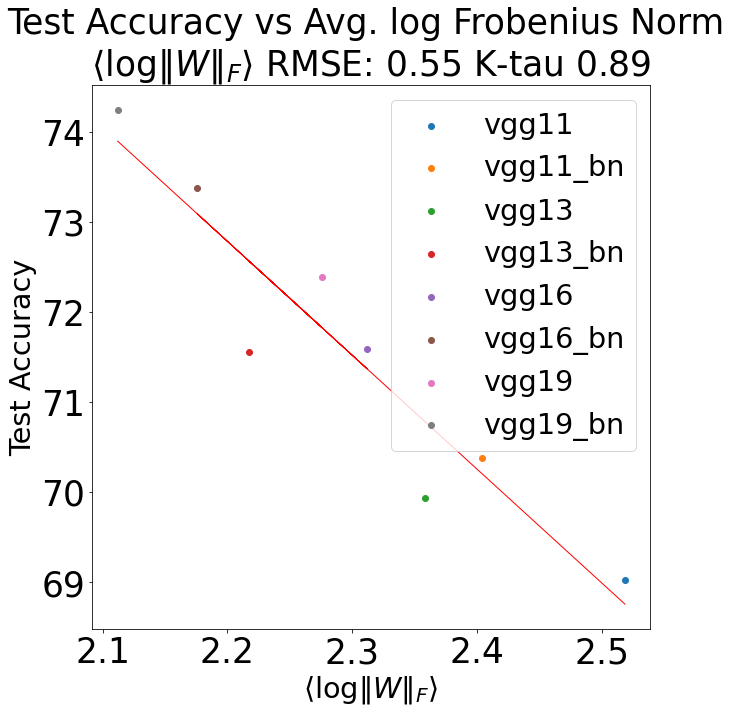

saving img/VGG_alpha_accs.png


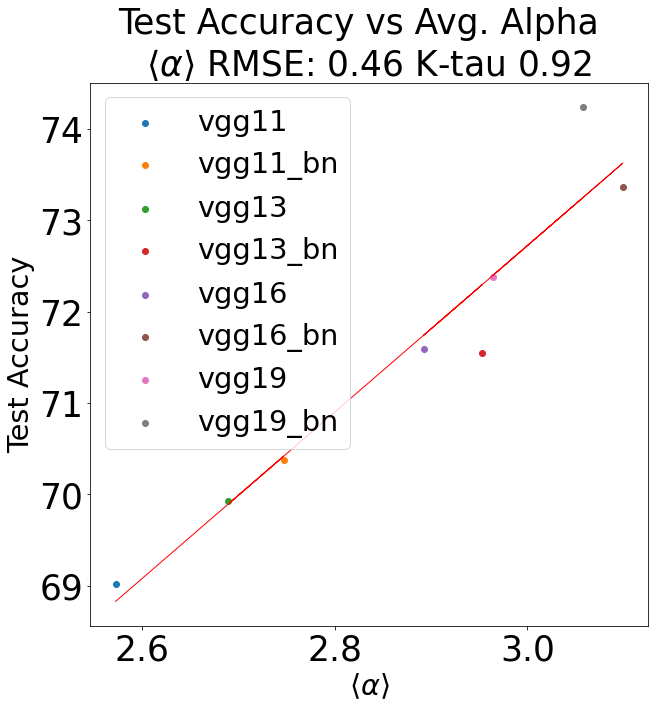

saving img/VGG_alpha_weighted_accs.png


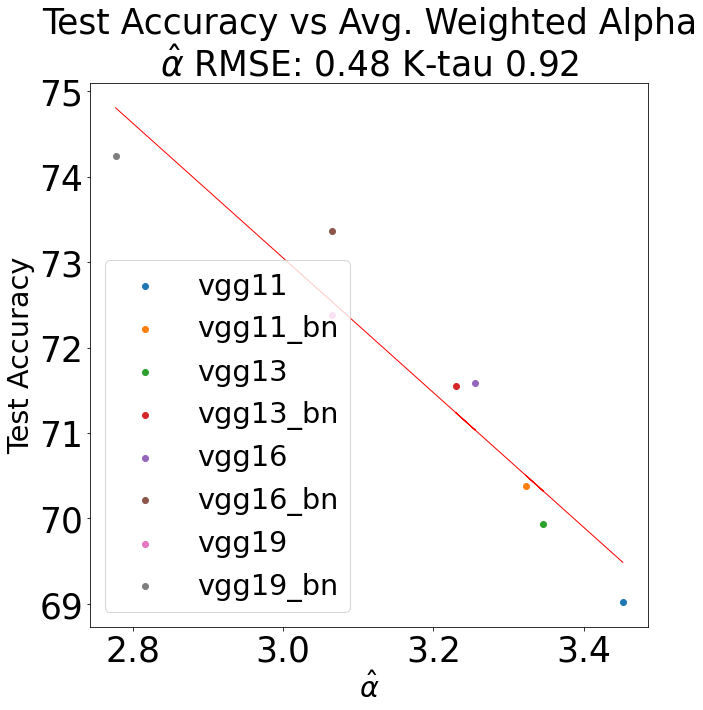

saving img/VGG_log_spectral_norm_accs.png


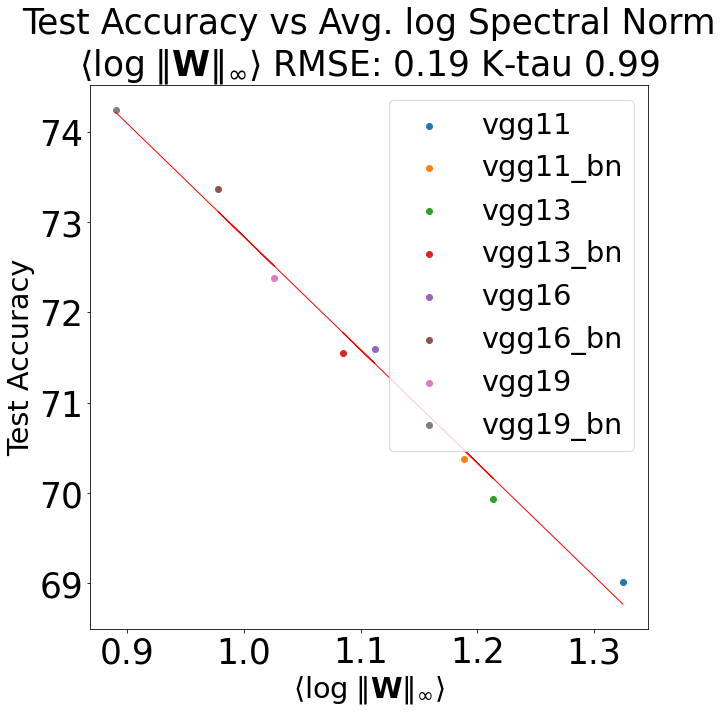

saving img/VGG_stable_rank_accs.png


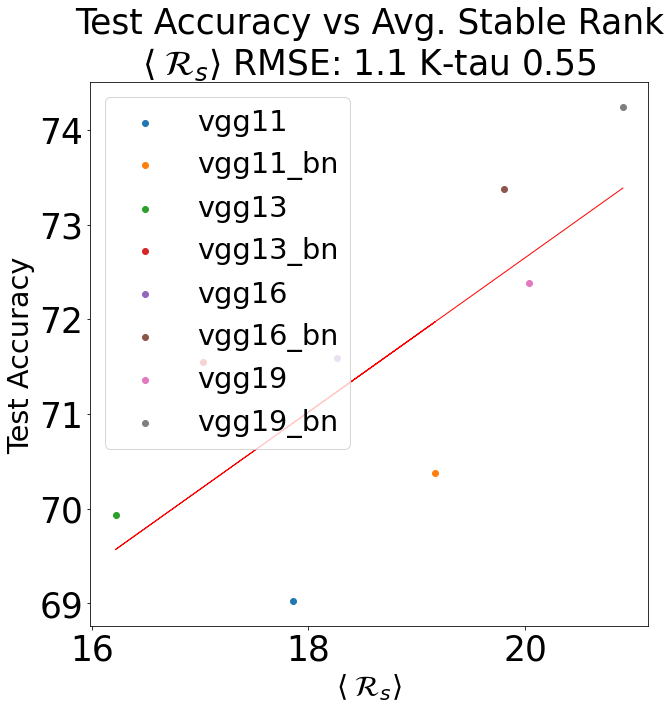

saving img/VGG_mp_softrank_accs.png


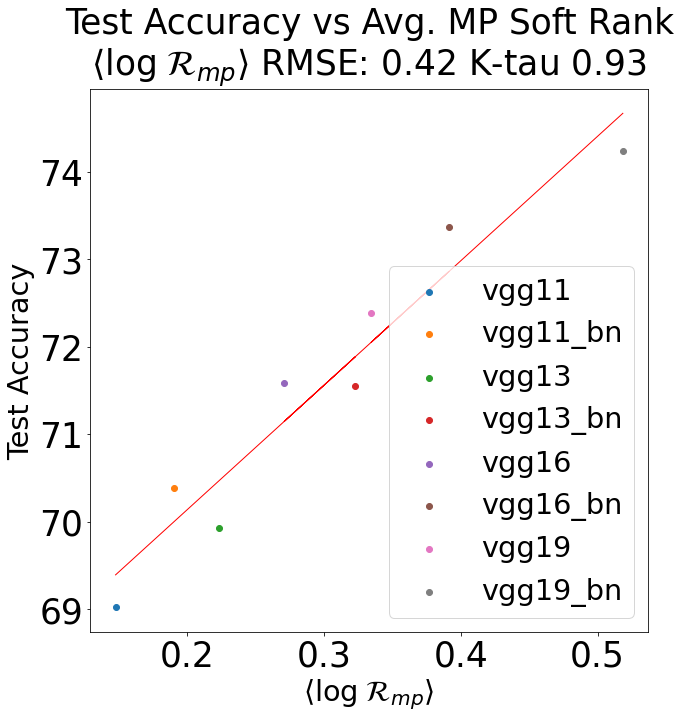

saving img/VGG_log_alpha_norm_accs.png


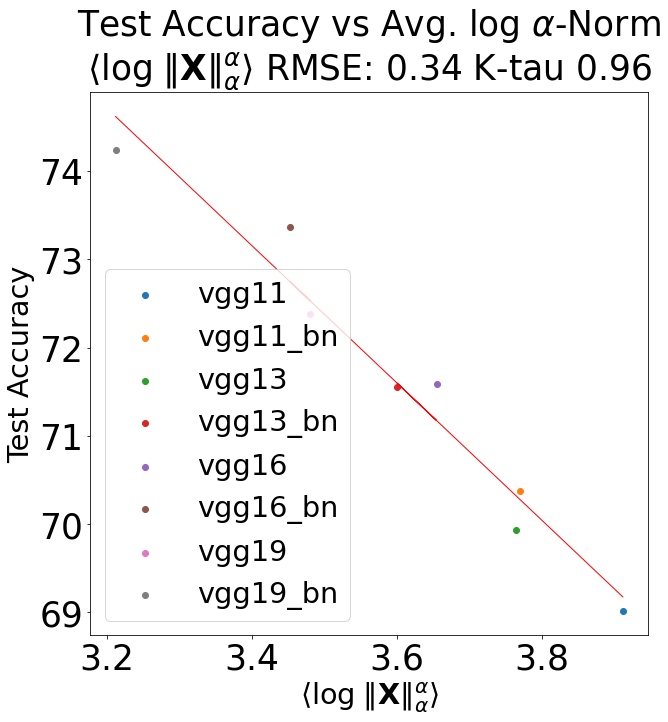

In [18]:
MP.plot_all_metrics_vs_test_accuracies( 
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

In [19]:
all_summaries[0]

{'log_norm': 2.5185176415590362,
 'alpha': 2.5724933319813803,
 'alpha_weighted': 3.4519501738297196,
 'log_alpha_norm': 3.9115819017727302,
 'log_spectral_norm': 1.324667383666083,
 'stable_rank': 17.85955167356445,
 'mp_softrank': 0.14740982700007024}

saving img/VGG_all_log_norm_hist.png


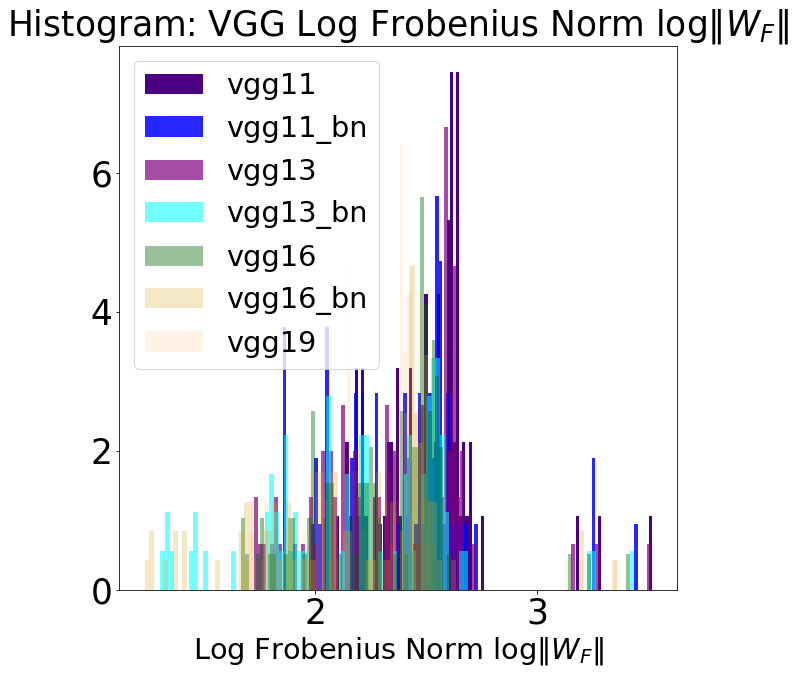

saving img/VGG_fnl_log_norm_hist.png


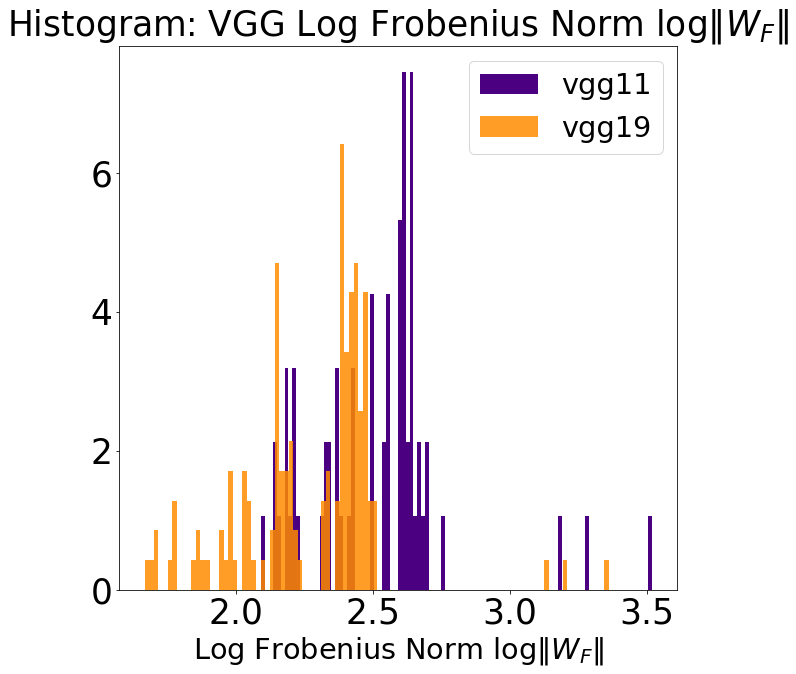

saving img/VGG_all_alpha_hist.png


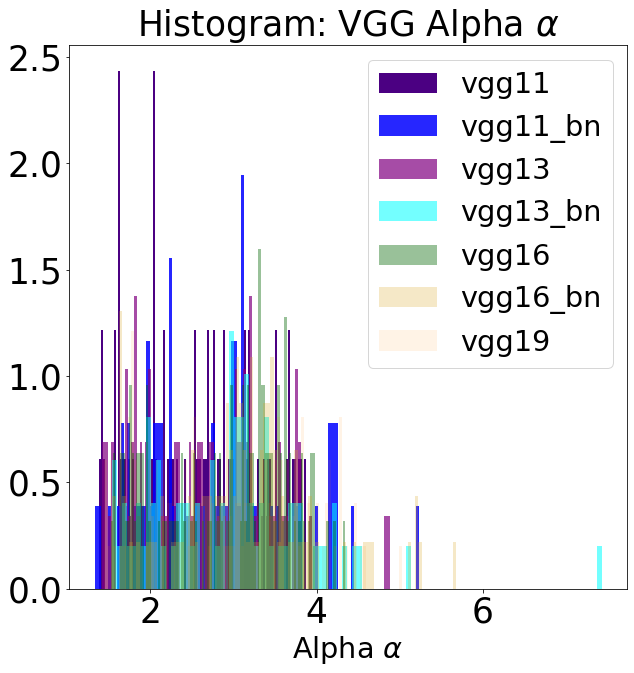

saving img/VGG_fnl_alpha_hist.png


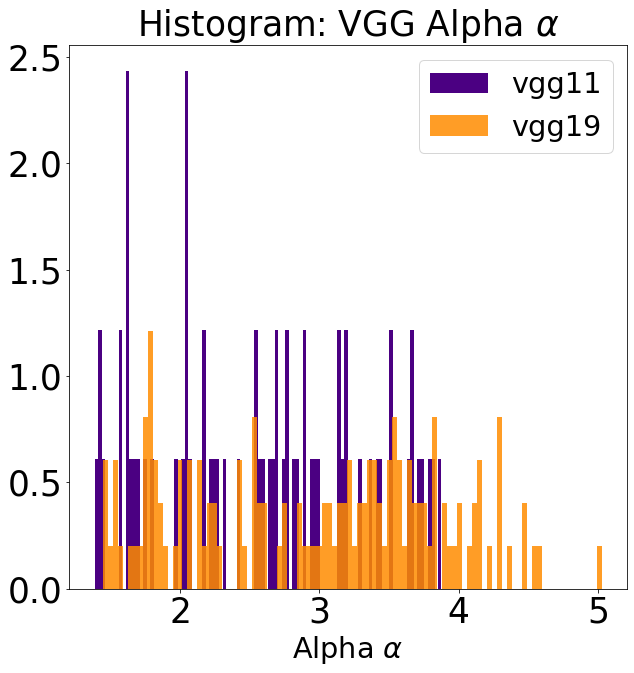

saving img/VGG_all_alpha_weighted_hist.png


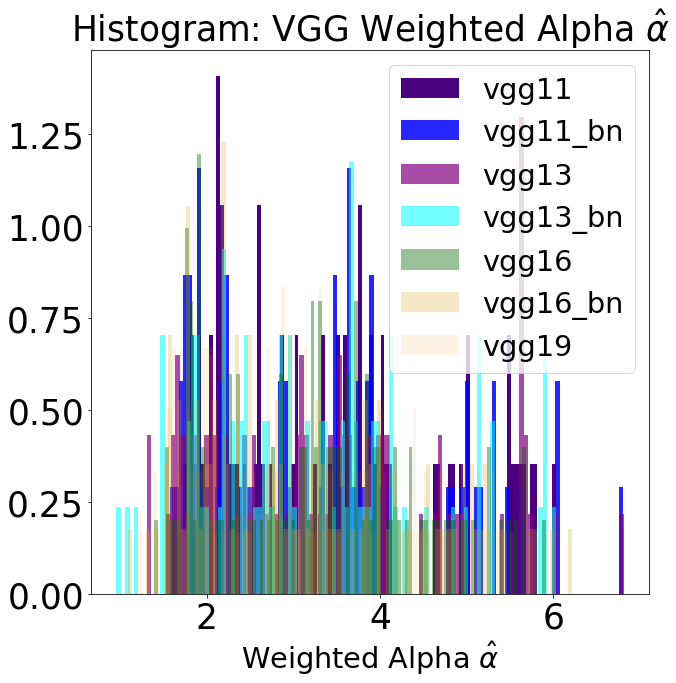

saving img/VGG_fnl_alpha_weighted_hist.png


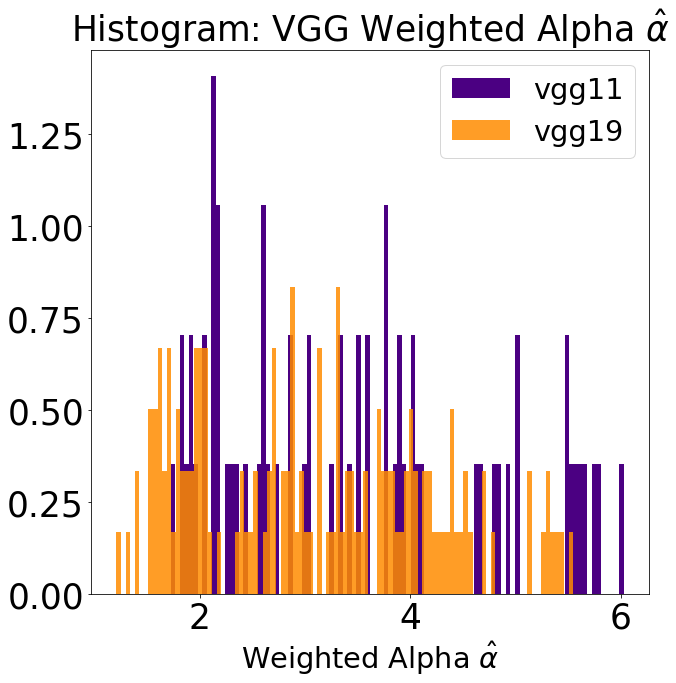

saving img/VGG_all_stable_rank_hist.png


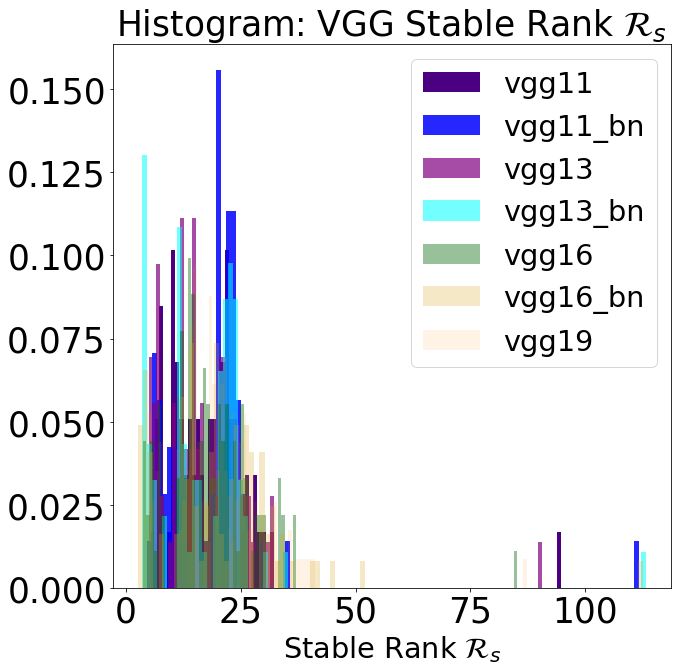

saving img/VGG_fnl_stable_rank_hist.png


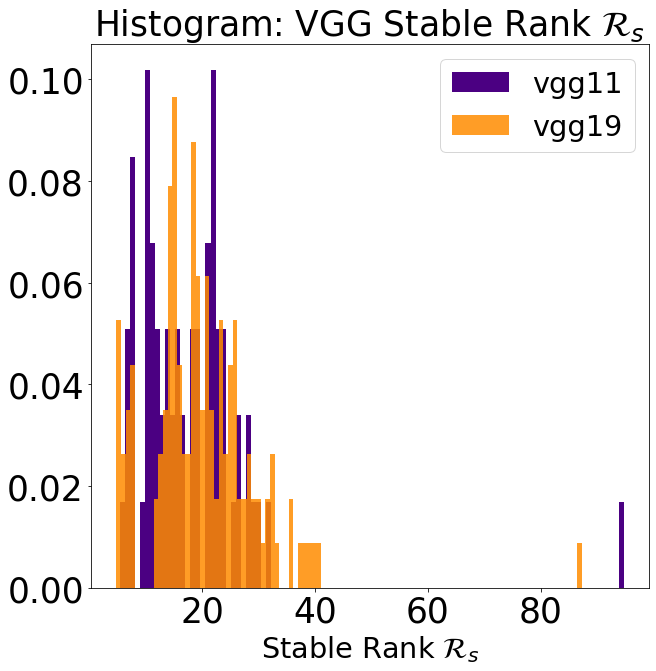

saving img/VGG_all_log_spectral_norm_hist.png


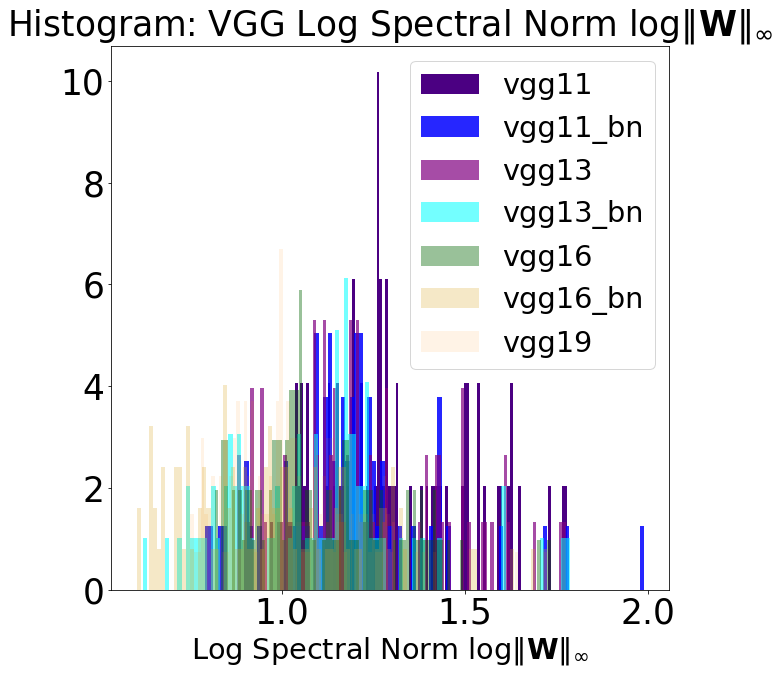

saving img/VGG_fnl_log_spectral_norm_hist.png


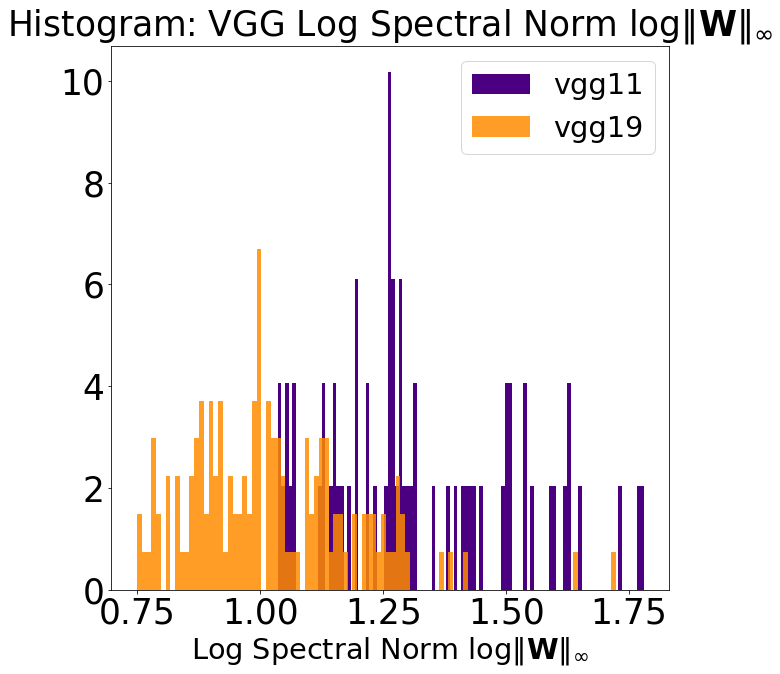

saving img/VGG_all_mp_softrank_hist.png


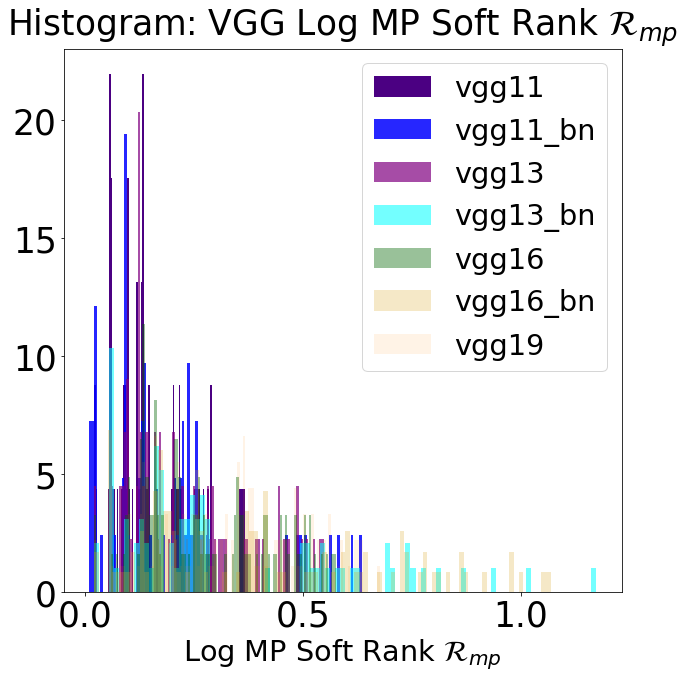

saving img/VGG_fnl_mp_softrank_hist.png


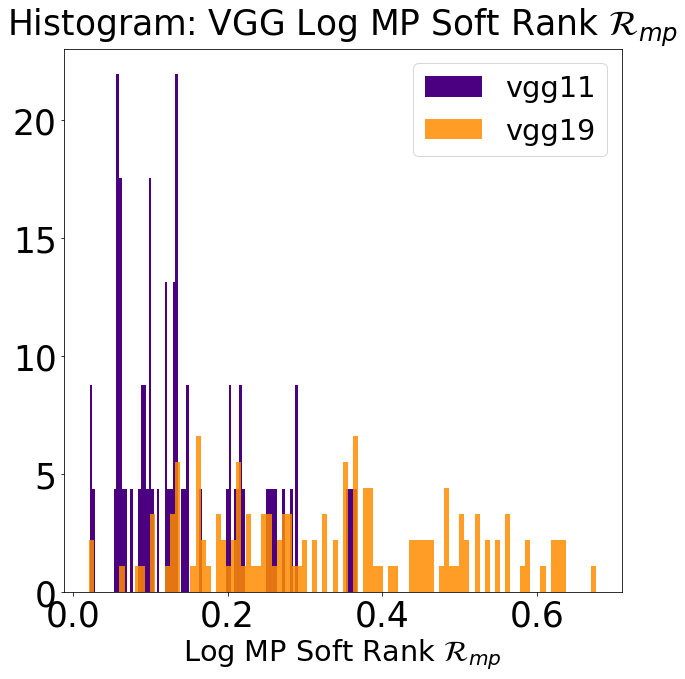

saving img/VGG_all_log_alpha_norm_hist.png


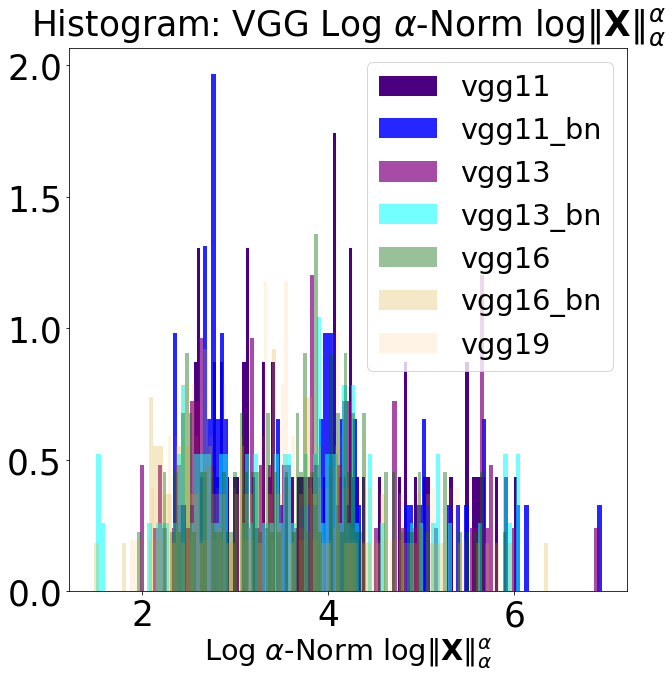

saving img/VGG_fnl_log_alpha_norm_hist.png


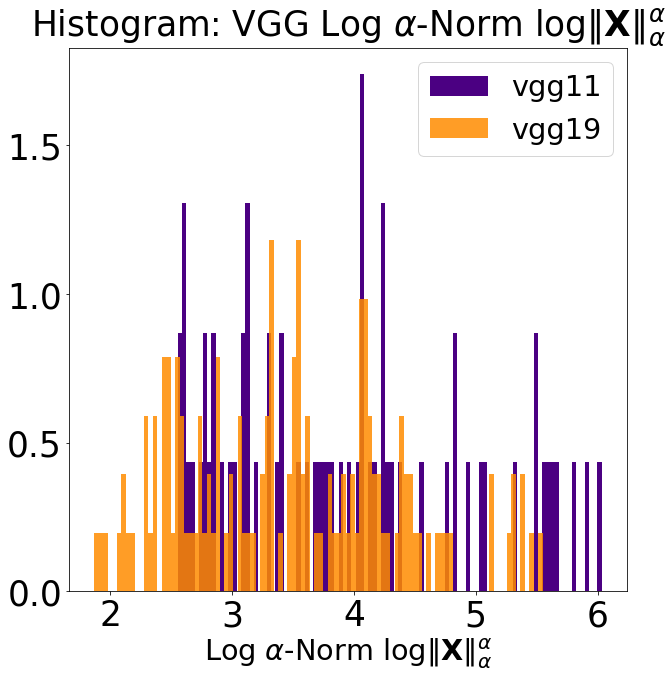

In [20]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)

saving img/VGG_all_log_norm_depth.png


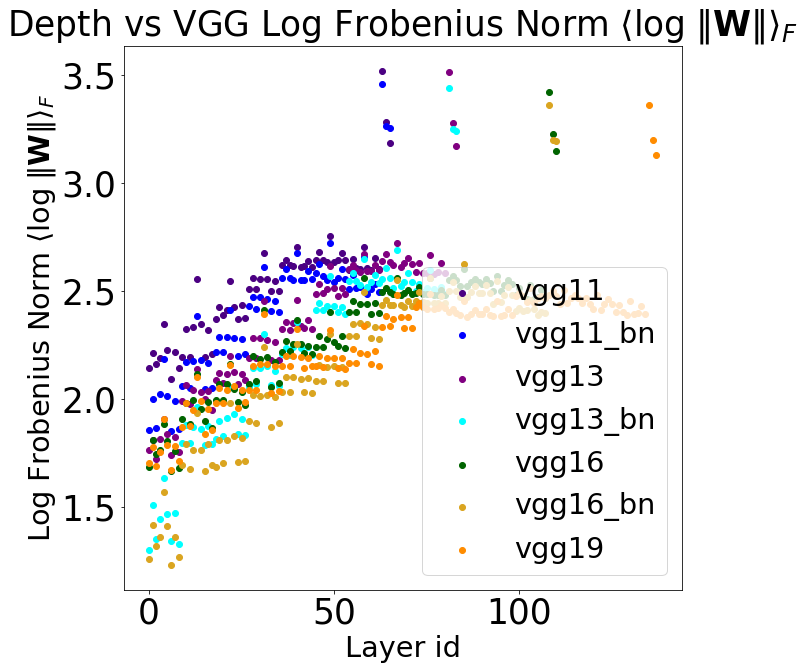

saving img/VGG_fnl_log_norm_depth.png


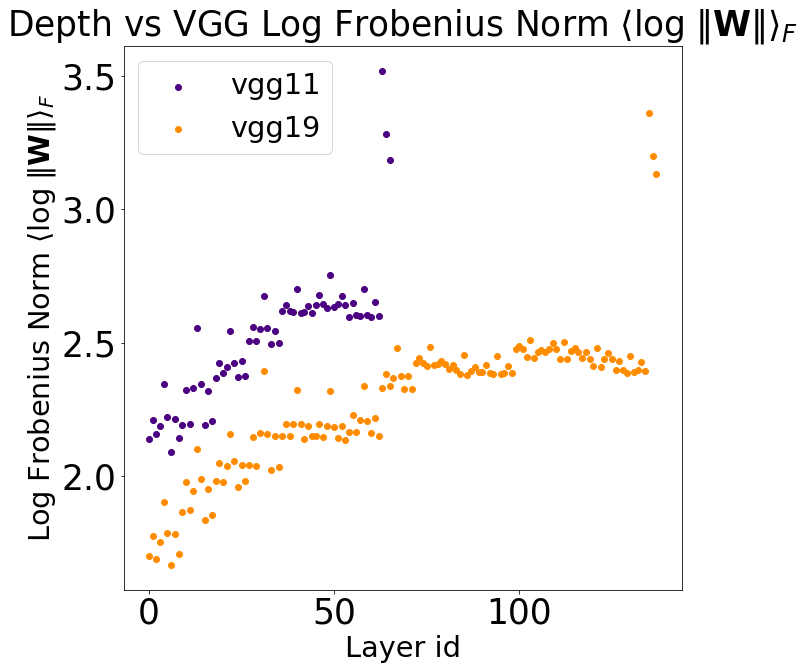

saving img/VGG_all_alpha_depth.png


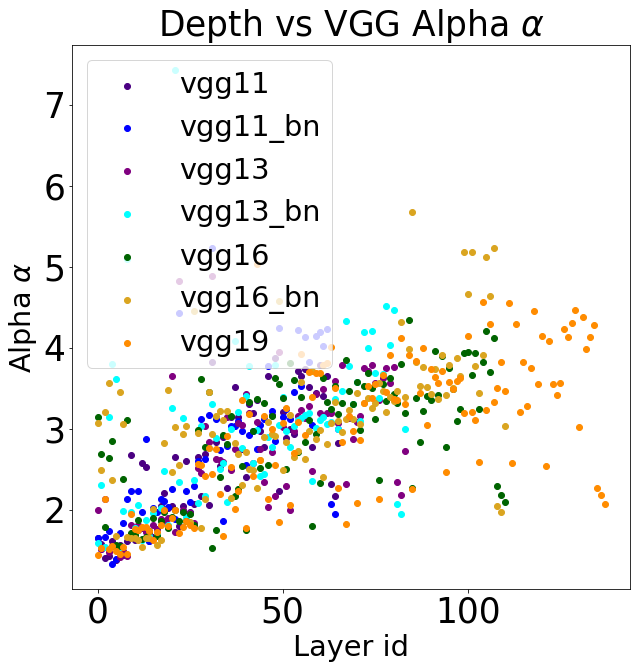

saving img/VGG_fnl_alpha_depth.png


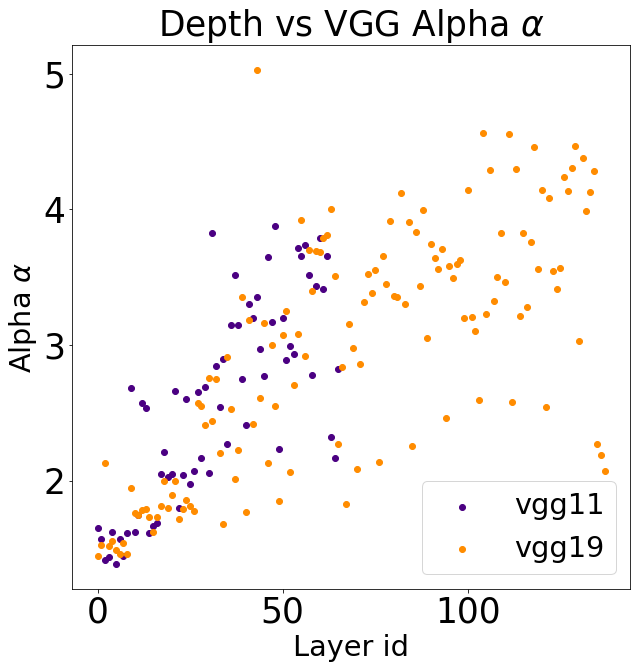

saving img/VGG_all_alpha_weighted_depth.png


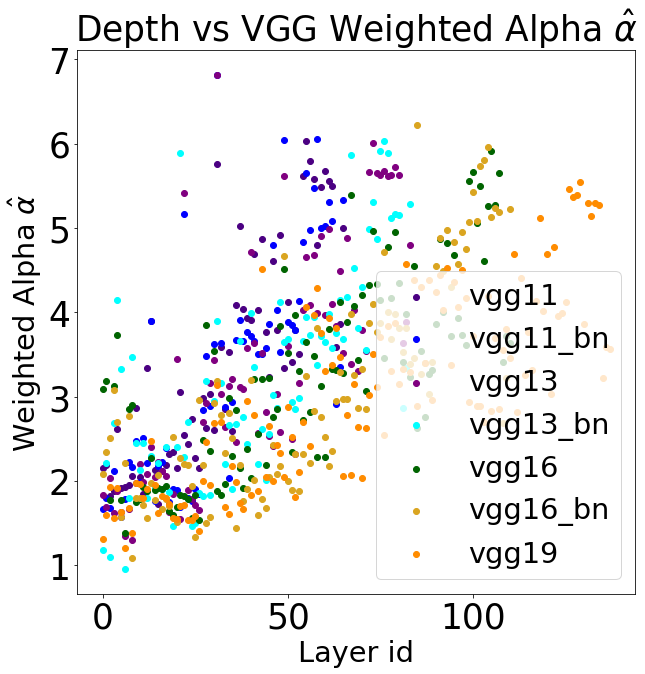

saving img/VGG_fnl_alpha_weighted_depth.png


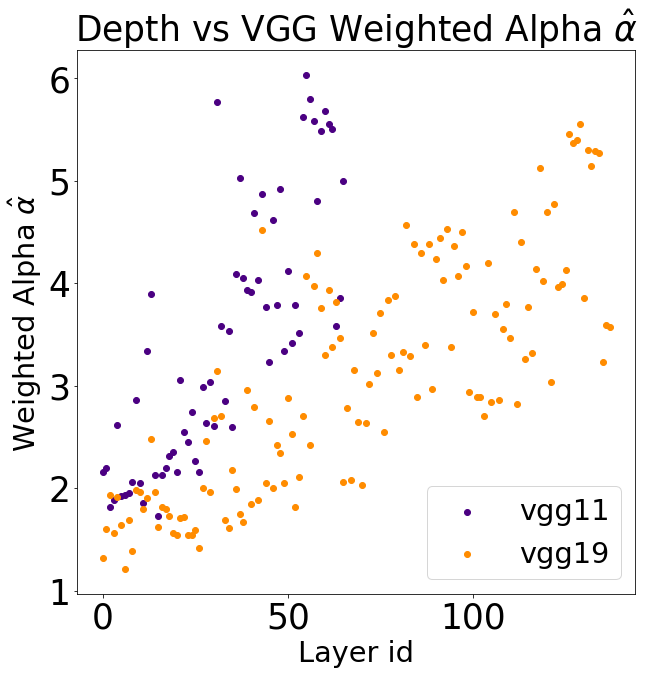

saving img/VGG_all_stable_rank_depth.png


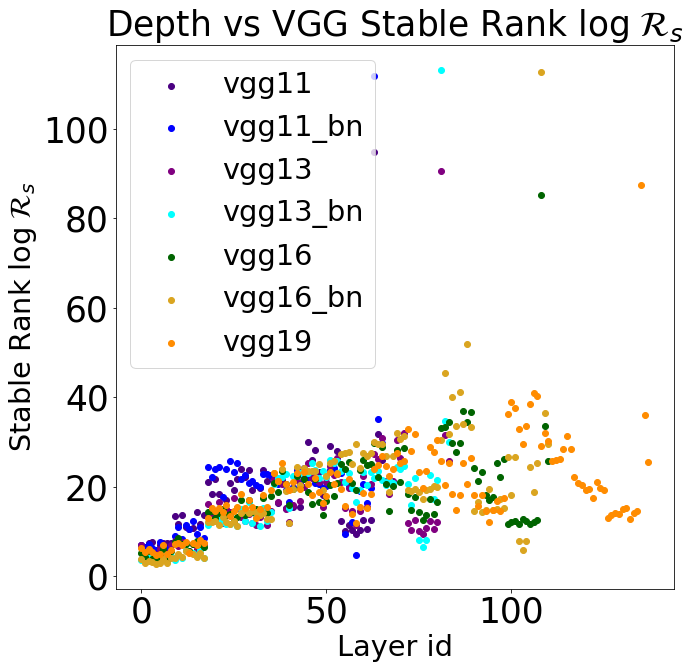

saving img/VGG_fnl_stable_rank_depth.png


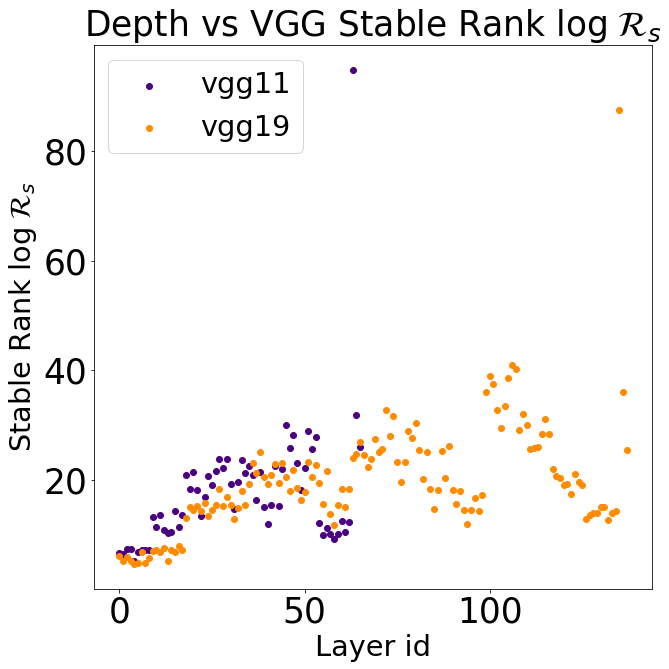

saving img/VGG_all_log_spectral_norm_depth.png


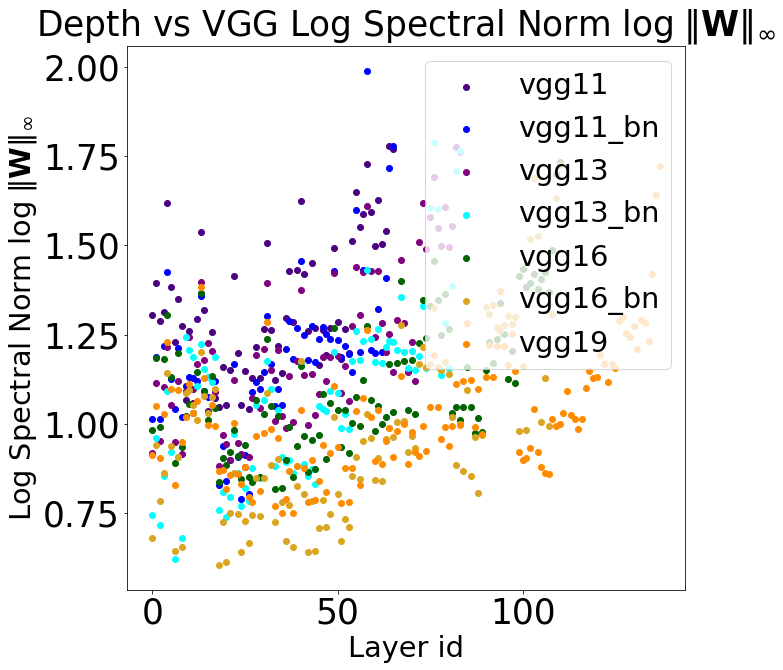

saving img/VGG_fnl_log_spectral_norm_depth.png


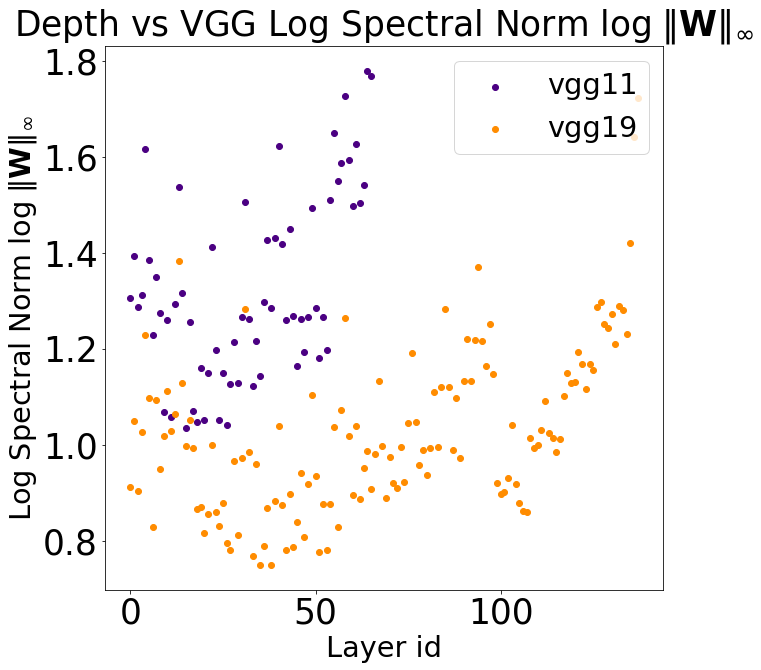

saving img/VGG_all_mp_softrank_depth.png


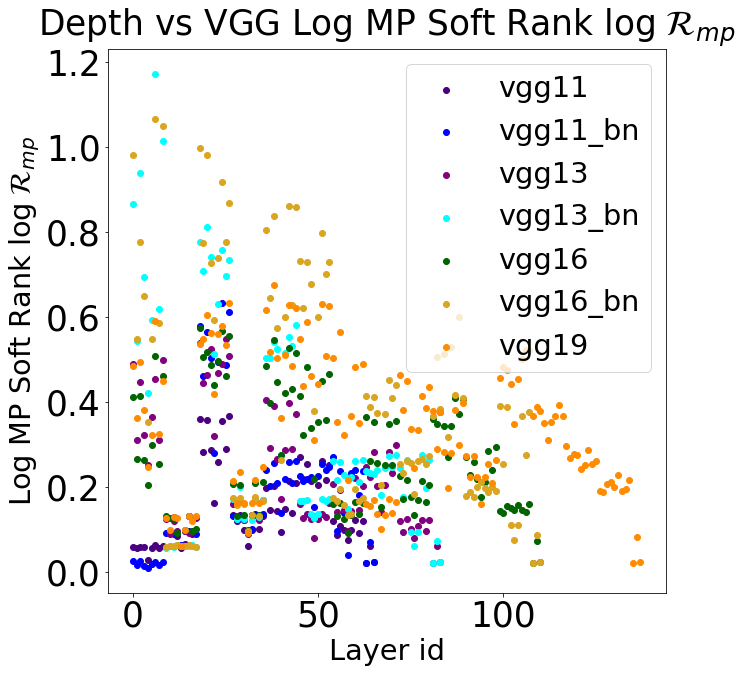

saving img/VGG_fnl_mp_softrank_depth.png


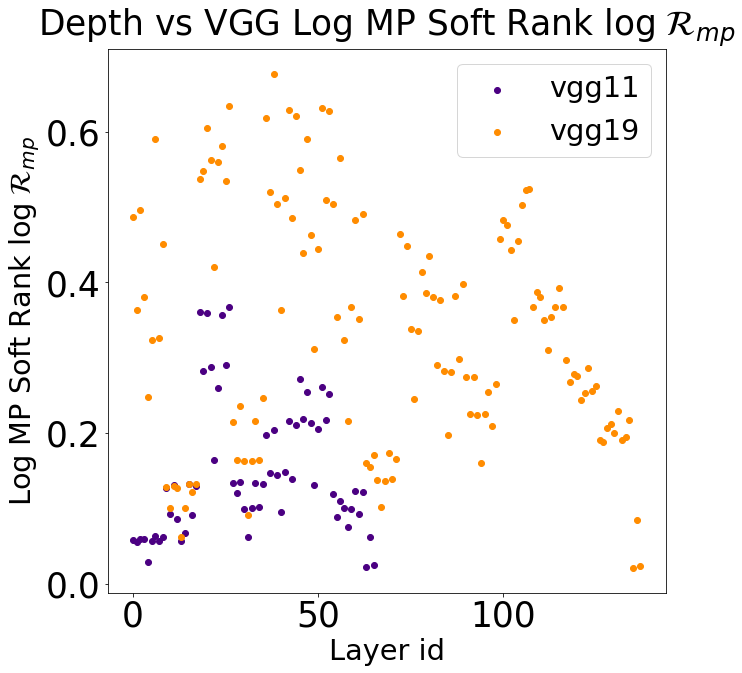

saving img/VGG_all_log_alpha_norm_depth.png


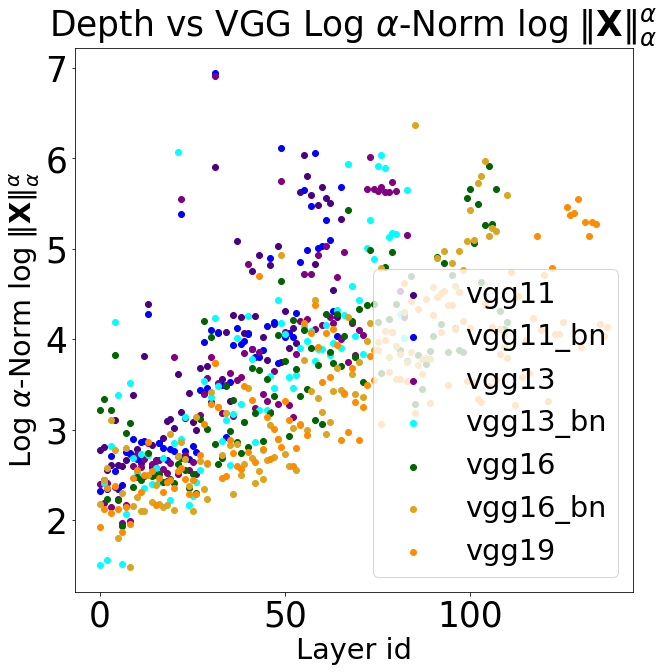

saving img/VGG_fnl_log_alpha_norm_depth.png


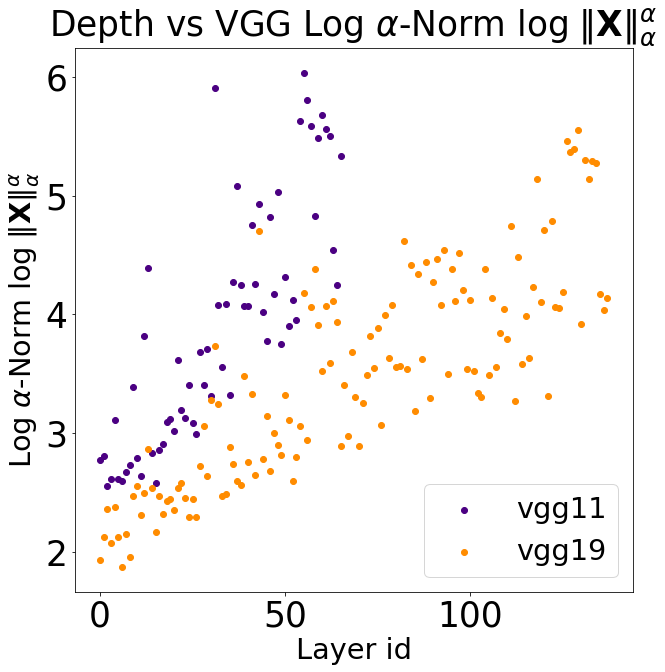

In [21]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)


In [22]:
all_details[0]

layer_id  name         D       M        N     alpha  alpha_weighted  \
0         5  None  0.169486    64.0    128.0  1.650138        2.154538   
1         5  None  0.179739    64.0    128.0  1.572975        2.193872   
2         5  None  0.194281    64.0    128.0  1.412104        1.817862   
3         5  None  0.181339    64.0    128.0  1.434591        1.881963   
4         5  None  0.162326    64.0    128.0  1.618499        2.618226   
..      ...   ...       ...     ...      ...       ...             ...   
61       20  None  0.044012   512.0    512.0  3.409722        5.552120   
62       20  None  0.031514   512.0    512.0  3.655300        5.497978   
63       25  None  0.032563  4096.0  25088.0  2.325065        3.583809   
64       28  None  0.030891  4096.0   4096.0  2.167513        3.858526   
65       31  None  0.039773  1000.0   4096.0  2.825653        4.999373   

    has_esd  lambda_max         layer_type  ...  rand_sigma_mp  rank_loss  \
0       1.0   20.214882  LAYER_TYPE.CONV2D  ...       0.999999        0.0   
1       1.0   24.815761  LAYER_TYPE.CONV2D  ...       0.999999        0.0   
2       1.0   19.379514  LAYER_TYPE.CONV2D  ...       0.999999        0.0   
3       1.0   20.504353  LAYER_TYPE.CONV2D  ...       0.999999        0.0   
4       1.0   41.465559  LAYER_TYPE.CONV2D  ...       0.999998        0.0   
..      ...         ...                ...  ...            ...        ...   
61      1.0   42.493275  LAYER_TYPE.CONV2D  ...       0.992090        0.0   
62      1.0   31.923570  LAYER_TYPE.CONV2D  ...       0.983789        0.0   
63      1.0   34.784030   LAYER_TYPE.DENSE  ...       0.898154        0.0   
64      1.0   60.278519   LAYER_TYPE.DENSE  ...       0.959863        0.0   
65      1.0   58.786867   LAYER_TYPE.DENSE  ...       1.000000        0.0   

     rf     sigma  sigma_mp  slice_id  stable_rank    sv_max       xmax  \
0   9.0  0.122865  0.637910       0.0     6.832892  4.496096  20.214882   
1   9.0  0.099742  0.690430       1.0     6.557304  4.981542  24.815761   
2   9.0  0.057706  0.630410       2.0     7.468672  4.402217  19.379514   
3   9.0  0.061460  0.649453       3.0     7.546826  4.528173  20.504353   
4   9.0  0.116885  0.637676       4.0     5.371114  6.439376  41.465559   
..  ...       ...       ...       ...          ...       ...        ...   
61  9.0  0.390909  0.993848       7.0    10.541428  6.518687  42.493275   
62  9.0  0.409722  0.985547       8.0    12.456979  5.650095  31.923570   
63  1.0  0.028604  0.619980       0.0    94.707780  5.897799  34.784030   
64  1.0  0.034133  0.963086       0.0    31.849728  7.763924  60.278519   
65  1.0  0.260808  0.800547       0.0    26.033945  7.667259  58.786867   

        xmin  
0   0.555443  
1   0.403412  
2   0.071895  
3   0.093104  
4   0.772843  
..       ...  
61  2.620948  
62  2.241404  
63  0.380772  
64  0.341789  
65  5.730350  

[66 rows x 31 columns]

In [23]:
for k, v in all_summaries[0].items():
    print('{}: {:f}'.format(k,v))

log_norm: 2.518518
alpha: 2.572493
alpha_weighted: 3.451950
log_alpha_norm: 3.911582
log_spectral_norm: 1.324667
stable_rank: 17.859552
mp_softrank: 0.147410


In [24]:
all_summaries

[{'log_norm': 2.5185176415590362,
  'alpha': 2.5724933319813803,
  'alpha_weighted': 3.4519501738297196,
  'log_alpha_norm': 3.9115819017727302,
  'log_spectral_norm': 1.324667383666083,
  'stable_rank': 17.85955167356445,
  'mp_softrank': 0.14740982700007024},
 {'log_norm': 2.4040395419861342,
  'alpha': 2.746966118833619,
  'alpha_weighted': 3.3225589577723644,
  'log_alpha_norm': 3.7696396657544926,
  'log_spectral_norm': 1.1883585503805474,
  'stable_rank': 19.171821328511218,
  'mp_softrank': 0.1898590571848256},
 {'log_norm': 2.3579769504569716,
  'alpha': 2.6896963226854465,
  'alpha_weighted': 3.3459759337607844,
  'log_alpha_norm': 3.7636939521538473,
  'log_spectral_norm': 1.2137233793585331,
  'stable_rank': 16.219071101920626,
  'mp_softrank': 0.22273844555517844},
 {'log_norm': 2.2174071131544815,
  'alpha': 2.953077293803465,
  'alpha_weighted': 3.2295413654007246,
  'log_alpha_norm': 3.600359585944151,
  'log_spectral_norm': 1.0845453692136475,
  'stable_rank': 17.022217